In [ ]:
from abc import ABC, abstractmethod
import matplotlib as plt 
from matplotlib import pyplot
import numpy as np
import typing
import itertools as it
from pprint import pprint
from collections import namedtuple, deque
from datetime import datetime

import networkx as nx
from networkx import *



# Example time_step
sample_input_0 = {
    "requests": [
         { 
           "name": "sample", 
           "start": (10,10), 
           "end": (5,5) 
        }
      ] 
   }
    
    
sample_input_1 = {
    "requests": [
         { 
           "name": "Elon", 
           "start": (3,5), 
           "end": (8,7) 
        },
        { 
           "name": "George", 
           "start": (1,2), 
           "end": (4,3) 
        }
      ] 
   }

sample_input_2 = {
    "requests": [
         { 
           "name": "Elton", 
           "start": (8,8), 
           "end": (0,1) 
        },
        { 
           "name": "Georgia", 
           "start": (3,9), 
           "end": (3,0) 
        }
      ] 
   }


class Map():
    """
    TODO: Docstring
    TODO: Should I also be polymorphic for more complicated grids then just Manahattan maps?
    """
    def __init__(self, map_size):
        self.map_size = map_size
        self.grid = np.ndarray((map_size, map_size))
        
    def visualize_map(self, car=None, passenger_list=None):
        # make values from -5 to 5, for this example
        map_array = np.zeros((self.map_size,self.map_size))

        # make a color map of fixed colors
        cmap = plt.colors.ListedColormap(['blue','white','red'])
        bounds=[-6,-2,2,6]
        norm = plt.colors.BoundaryNorm(bounds, cmap.N)

        # tell imshow about color map so that only set colors are used
        img = pyplot.imshow(map_array,interpolation='nearest',
                            cmap = cmap,norm=norm)

        # make a color bar
        pyplot.colorbar(img,cmap=cmap,
                        norm=norm,boundaries=bounds,ticks=[-5,0,5])

        pyplot.show()

In [ ]:
sample_input = {
    "requests": [
         { 
           "name": "Elton", 
           "start": (8,8), 
           "end": (0,1) 
        },
        { 
           "name": "Georgia", 
           "start": (3,9), 
           "end": (3,0) 
        },
        { 
           "name": "Elon", 
           "start": (3,5), 
           "end": (8,7) 
        },
        { 
           "name": "George", 
           "start": (1,2), 
           "end": (4,3) 
        }
      ]
}

listy = []
for passenger in sample_input["requests"]:
    listy.append((passenger["name"], '+'))
    listy.append((passenger["name"], '-'))
    
    

In [ ]:
list(it.permutations([1,2,3], 3))

### REMEMBER YOU ALREADY DID A BUNCH OF THE ALGO STUFF ON OTHER LAPPTOP

In [ ]:
# Itinerary = namedtuple("Itinerary", ["to_pickup", "to_dropoff", "hold_dropoff"], defaults=[set(),set(),set()])
Location = namedtuple("Location", ("x", "y"))
Velocity = namedtuple("Velocity", ("dx", "dy"))
Stop = namedtuple("Stop", ("location", "pickup_or_dropoff", "passenger")) # TODO: ENUMERATED TYPE

In [ ]:
class Passenger():
    identifier = 0
    """
    TODO: Docstring
    """
    def __init__(self, name, pickup_location: Location, dropoff_location: Location):
        self.name = name
        self.identifier = Passenger.identifier
        Passenger.identifier += 1
        self.is_in_car = False
        self.pickup_location = pickup_location
        self.dropoff_location = dropoff_location
        self.time_since_requested_pickup = datetime.now()
        self.time_picked_up = None
        self.time_since_picked_up = None
        self.time_dropped_off = None
        

In [ ]:
class Simulator():
    """
    TODO: Docstring
    """
    def __init__(self, optimizer=None, planner=None, map_size=10, map_scale_block_to_km=1, car_origin=(0,0), max_time=None):
        self.current_timestep = 0
        print("timestep: {}".format(self.current_timestep))
        self.mappy = Map(map_size)
        self.auto_car = Car(car_origin)
        print("current car location: {}".format(self.auto_car.current_location))

        self.optimizer = optimizer
        pass
    
    def step_forward(self, request_list=[]):
        if request_list:
            for passenger_dict in request_list["requests"]:
                passenger = Passenger(
                    name=passenger_dict["name"],
                    pickup_location=Location(*passenger_dict["start"]),
                    dropoff_location=Location(*passenger_dict["end"]))
                self.auto_car.add_passenger_to_itinerary(passenger) # [for passenger in request_list]
    
        self.auto_car.drive_for_one_timestep()
        
        self.current_timestep += 1
        print("timestep: {}".format(self.current_timestep))
        print("current car location: {}".format(self.auto_car.current_location))
        
    def visualize_map():
        pass
    
    def run_simulation(self, steps=20):
        self.step_forward(sample_input_0)
        self.step_forward()
        self.step_forward()
        self.step_forward()
        self.step_forward(sample_input_1)
        self.step_forward()
        self.step_forward()
        self.step_forward()
        self.step_forward()
        while self.auto_car.current_plan:
            self.step_forward()
        print("All done driving for today!!!")
    
    

In [ ]:
class StrategicRouteOptimizer(object):
    """
    TODO: 
    """
    def __init__(self, passenger_list):
        """
        Looks at passeneger list (and potentially other context) and chooses the ideal optimizer 
            for the current situation. Currently shortcut for nonsense.
        """
        self.passenger_list = passenger_list
        print(passenger_list)
        self.active_optimizer = self._select_optimizer_from_context()
    
    def _select_optimizer_from_context(self):
        """
        Dummied for the time being.
        """
        return DumbSOPOptimizer()
        
    def _translate_passenger_list_to_graph(self, passenger_list):
        graph = passenger_list
        return graph
    
    def _translate_graph_to_itinerary(self, graph): #: Graph) -> Itinerary:
        itinerary = graph
        return graph
        
    def generate_optimal_route(self): # -> itinerary    optimal here in a non-technical sense
        graph = self._translate_passenger_list_to_graph(self.passenger_list)
        optimal_graph = self.active_optimizer.optimize_sequential_order_problem(self.passenger_list)
        itinerary = self._translate_graph_to_itinerary(optimal_graph)
        return itinerary 

class AbstractSOPOptimizer(ABC):
    """
    TODO: Docstring
    Strategy pattern to 
    """
    @abstractmethod
    def __init__(self):
        pass
    
    @abstractmethod
    def optimize_sequential_order_problem(self, passenger_list): #: Graph):
        pass
    

class DumbSOPOptimizer(AbstractSOPOptimizer):
    """
    Optimizer that simply uses Euclidean (or Manahattan) distance to choose destination
        ordering by nearness /only/ to current position. 
    """
    def __init__(self):
        self.itinerary = deque()
        
    def optimize_sequential_order_problem(self, passenger_graph): #: Graph) -> Graph:
        for passenger in passenger_graph:
            if not passenger.is_in_car:
                self.itinerary.appendleft(Stop(passenger.pickup_location, "pickup", passenger))
            self.itinerary.appendleft(Stop(passenger.dropoff_location, "dropoff", passenger))
        return self.itinerary
        
        
class BruteForceSOPOptimizer(AbstractSOPOptimizer):
    """
    TODO: Docstring
    """
    def __init__(self, passenger_list):
        # convert into form useable for bruteforce sequential ordering problem, with constraints and minimal metadata
        abbr_stop = namedtuple("abbr_stop", ("name", "location"))
        dropoffs = []
        pickups = []
        constrained_dropoffs = []
        for passenger in passenger_list:
            if passenger.is_in_car:
                
                
                

In [ ]:
class Car():
    """
    TODO: Docstring
    """
    def __init__(self, initial_location: tuple):
        self.current_location = Location(*initial_location)
        self.history = []
        self.passenger_log = []
        self.next_stop = None
        self.current_velocity = Velocity(0,0)
        self.current_users = []
        self.current_plan = None
        self.need_to_reoptimize = False  # will be a state machine kind of thing
                                
    def add_passenger_to_itinerary(self, passenger): # TODO: change name
        self.current_users.append(passenger)
        self.need_to_reoptimize = True
        
    def optimize_route(self) -> deque:
        print("REOPTIMIZING ROUTTTTEEEE!!!!")
        # stand-in dummy one, first come, first serve. returns active_users list
        self.optimizer = StrategicRouteOptimizer(self.current_users)
        # try except
        self.current_plan = self.optimizer.generate_optimal_route()
        print(self.current_plan)
        self.need_to_reoptimize = False
    
    def set_next_step(self):
        pass
    
    def set_next_stop(self):
        self.next_stop = self.current_plan[-1]

    def plan_path_to_next_stop(self): # more like a trajectory in some senses, but whatever, will get back to it.
        # another strategy potentially; this is just a stand-in dummy one
        if self.current_location.x != self.next_stop.location.x: # Manhattan grid, drive along x until aligned with destination, then along y
            self.current_velocity = Velocity(np.sign(self.next_stop.location.x - self.current_location.x), 0)
        elif self.current_location.y != self.next_stop.location.y:
            self.current_velocity = Velocity(0, np.sign(self.next_stop.location.y - self.current_location.y))
        else:
            self.current_velocity = Velocity(0, 0)
        
    def drive_for_one_timestep(self):
        if self.need_to_reoptimize: self.optimize_route()
        self.set_next_stop()
        self.plan_path_to_next_stop()
    
        self.current_location = Location( # where in this is self-monitoring for staying in bounds going to occur? probably can be relegated to only request ingestion since there's no obstables
                                    self.current_location.x + self.current_velocity.dx,
                                    self.current_location.y + self.current_velocity.dy
                                )
        if self.current_location == self.next_stop.location:
            print("{} HERE FOR {}".format(self.next_stop.pickup_or_dropoff, self.next_stop.passenger.name))
            if self.next_stop.pickup_or_dropoff == "dropoff":
                self.next_stop.passenger.time_dropped_off = datetime.now()
                self.next_stop.passenger.is_in_car = False
            elif self.next_stop.pickup_or_dropoff == "pickup":
                self.next_stop.passenger.time_picked_up = datetime.now()
                self.next_stop.passenger.is_in_car = True

            self.current_plan.pop()
        
    def pickup_passenger(self, passenger):
        passenger.time_since_picked_up = datetime.now()
        self.itinerary.hold_dropoff.remove(passenger)
        self.itinerary.add_dropoff.add(passenger)
        self.active_users.append(passenger)
        
    def dropoff_passenger():
        pass

In [ ]:
Graph = typing.NewType("Graph", list)

## EXAMPLE USAGE

In [ ]:
sim = Simulator()
sim.run_simulation()

In [ ]:
N=10
G=nx.grid_2d_graph(N,N)




pickups = [(0,0), (1,1), (2,2), (3,5), (9,9), (1,9)]
for pickup in pickups:
    
    nx.draw_networkx_nodes(G, pos,
                           nodelist=[pickup],
                           node_color='r',
                           node_size=50,
                           alpha=0.8)
    nx.draw_networkx_nodes(G, pos,
                           nodelist=[node for node in G.nodes if node != pickup],
                           node_color='b',
                           node_size=50,
                           alpha=0.8)

    # edges
    nx.draw_networkx_edges(G, pos, width=1.0, alpha=0.5)
    
    
    
def animate(i):
    x = np.linspace(0, 2, 1000)
    y = np.sin(2 * np.pi * (x - 0.01 * i))
    line.set_data(x, y)
    return line,

# call the animator.  blit=True means only re-draw the parts that have changed.
anim = animation.FuncAnimation(fig, animate, init_func=init,
                               frames=200, interval=20, blit=True)

# save the animation as an mp4.  This requires ffmpeg or mencoder to be
# installed.  The extra_args ensure that the x264 codec is used, so that
# the video can be embedded in html5.  You may need to adjust this for
# your system: for more information, see
# http://matplotlib.sourceforge.net/api/animation_api.html
# anim.to_html5_video()
anim.save('basic_animation.mp4', fps=30, extra_args=['-vcodec', 'libx264'])


plt.show()
# nx.draw_networkx_edges(G, pos,
#                        edgelist=[(0, 1), (1, 2), (2, 3), (3, 0)],
#                        width=8, alpha=0.5, edge_color='r')
# nx.draw_networkx_edges(G, pos,
#                        edgelist=[(4, 5), (5, 6), (6, 7), (7, 4)],
#                        width=8, alpha=0.5, edge_color='b')

# labels = {}
# labels[0] = r'$a$'
# labels[1] = r'$b$'
# labels[2] = r'$c$'
# labels[3] = r'$d$'
# labels[4] = r'$\alpha$'
# labels[5] = r'$\beta$'
# labels[6] = r'$\gamma$'
# labels[7] = r'$\delta$'
# nx.draw_networkx_labels(G, pos, labels, font_size=16)

# plt.axis('off')
# plt.show()

In [2]:
import ffmpeg

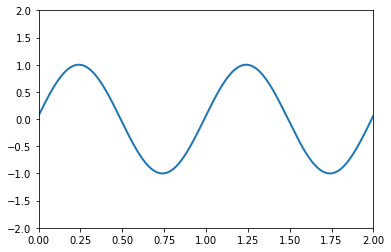

In [2]:
import numpy as np
from matplotlib import pyplot as plt
from matplotlib import animation

# First set up the figure, the axis, and the plot element we want to animate
fig = plt.figure()
ax = plt.axes(xlim=(0, 2), ylim=(-2, 2))
line, = ax.plot([], [], lw=2)

# initialization function: plot the background of each frame
def init():
    line.set_data([], [])
    return line,

# animation function.  This is called sequentially
def animate(i):
    x = np.linspace(0, 2, 1000)
    y = np.sin(2 * np.pi * (x - 0.01 * i))
    line.set_data(x, y)
    return line,

# call the animator.  blit=True means only re-draw the parts that have changed.
anim = animation.FuncAnimation(fig, animate, init_func=init,
                               frames=200, interval=20, blit=True)

# save the animation as an mp4.  This requires ffmpeg or mencoder to be
# installed.  The extra_args ensure that the x264 codec is used, so that
# the video can be embedded in html5.  You may need to adjust this for
# your system: for more information, see
# http://matplotlib.sourceforge.net/api/animation_api.html
# anim.to_html5_video()
anim.save('basic_animation.mp4', fps=30, extra_args=['-vcodec', 'libx264'])


plt.show()

In [ ]:
mappy = Map(10)

In [ ]:
mappy.visualize_map()

In [ ]:
BETA_MAP = np.ndarray((10,10))

In [ ]:
pyplot.imshow(BETA_MAP) 

In [ ]:
BETA_MAP[0,0] = 1 

In [ ]:
pyplot.imshow(BETA_MAP) 

In [ ]:
def map_to_graph():
    """
    Takes simple array map and turns it into a standard graph representation for algorithm usage.
    
    args: map (np.ndarray) - 
    
    returns: graph ()
    """

In [ ]:
class Itinerary():
    """
    TODO: Docstring
    """
    def __init__():
        pass
    
    def add_passenger():
        

In [ ]:
class MetricsPackage(ABC):
    """
    TODO: Docstring
    Generic metrics package that should be extensible for many situations using similar simulation/ same simulator
    """
    

In [ ]:
class GrassFireSOPOptimizer(AbstractSOPOptimizer):
    """
    TODO: Docstring
    """
    def __init__():
        pass
    
class MSTSOPOptimizer(AbstractSOPOptimizer):
    """
    TODO: Docstring
    """
    def __init__():
        pass
    
class NPResearchSOPOptimizer(AbstractSOPOptimizer):
    """
    TODO: Docstring
    """
    def __init__():
        pass

In [ ]:
TrivialOptimizer()